In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

@dataclass
class Landmark:
    x: float
    y: float
    landmark_id: int = None

# Definimos las conexiones de MediaPipe
mp_holistic = mp.solutions.holistic
POSE_CONNECTIONS = mp_holistic.POSE_CONNECTIONS
HAND_CONNECTIONS = mp_holistic.HAND_CONNECTIONS

def get_landmarks_from_image(image_path):

    with mp_holistic.Holistic(static_image_mode=True, min_detection_confidence=0.5) as holistic:

        image = cv2.imread(image_path)

        if image is None: 

            print("No hay foto crack")

            return None, None

        

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        results = holistic.process(image_rgb)

        

        all_lms = {}

        if results.pose_landmarks:

            all_lms["pose"] = [Landmark(lm.x, lm.y, i) for i, lm in enumerate(results.pose_landmarks.landmark)]

        if results.left_hand_landmarks:

            all_lms["left_hand"] = [Landmark(lm.x, lm.y) for lm in results.left_hand_landmarks.landmark]

        if results.right_hand_landmarks:

            all_lms["right_hand"] = [Landmark(lm.x, lm.y) for lm in results.right_hand_landmarks.landmark]

            

        return all_lms, image_rgb



def normalize_landmarks(landmarks, tam_target=100, margin=5):

    """

    Escala todos los puntos para que el cuerpo completo ocupe el máximo 

    espacio posible dentro del canvas, manteniendo la proporción.

    """

    # 1. Reunir todos los puntos (pose y manos) para calcular límites globales

    all_points = []

    for key in landmarks:

        all_points.extend(landmarks[key])

    

    if not all_points:

        return landmarks



    # 2. Encontrar extremos (Bounding Box)

    min_x = min(lm.x for lm in all_points)

    max_x = max(lm.x for lm in all_points)

    min_y = min(lm.y for lm in all_points)

    max_y = max(lm.y for lm in all_points)



    width = max_x - min_x

    height = max_y - min_y

    

    # Evitar división por cero

    if width == 0: width = 0.01

    if height == 0: height = 0.01



    # 3. Calcular escala manteniendo la relación de aspecto

    # Queremos que la dimensión más grande ocupe (tam_target - 2*margin)

    available_space = tam_target - (2 * margin)

    scale = available_space / max(width, height)



    # 4. Calcular desplazamientos para centrar el cuerpo

    # Centramos el contenido dentro del margen

    offset_x = margin + (available_space - width * scale) / 2

    offset_y = margin + (available_space - height * scale) / 2



    def transform(lm):

        # Normalizamos: (punto - min) escala el objeto a 0..X, luego sumamos el offset

        new_x = (lm.x - min_x) * scale + offset_x

        new_y = (lm.y - min_y) * scale + offset_y

        return Landmark(x=new_x, y=new_y, landmark_id=lm.landmark_id)



    normalized_data = {}

    for k, list_lms in landmarks.items():

        normalized_data[k] = [transform(lm) for lm in list_lms]

    return normalized_data



def plot_landmarks(landmarks, background_img=None, tam=512, is_normalized=True):

    # Usamos tam=512 por defecto para que la imagen final sea nítida

    if background_img is not None:

        img = background_img.copy()

    else:

        img = np.zeros((tam, tam, 3), dtype=np.uint8)

    

    h, w = img.shape[:2]



    def to_pixel(point):

        if is_normalized:

            # point.x está en rango 0-100

            return (int(point.x * w / 100), int(point.y * h / 100))

        return (int(point.x * w), int(point.y * h))



    # Dibujar conexiones

    lines = [("pose", POSE_CONNECTIONS), ("left_hand", HAND_CONNECTIONS), ("right_hand", HAND_CONNECTIONS)]

    for key, connections in lines:

        if key in landmarks:

            lms = landmarks[key]

            for start_idx, end_idx in connections:

                if start_idx < len(lms) and end_idx < len(lms):

                    cv2.line(img, to_pixel(lms[start_idx]), to_pixel(lms[end_idx]), (255, 255, 255), 2)



    # Dibujar puntos

    for p in landmarks.get("pose", []):

        cv2.circle(img, to_pixel(p), 4, (0, 0, 255), -1)

    for hand in ["left_hand", "right_hand"]:

        for p in landmarks.get(hand, []):

            cv2.circle(img, to_pixel(p), 3, (255, 0, 0), -1)



    return img

2026-01-27 17:29:54.094423: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-27 17:29:54.094467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-27 17:29:54.096062: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-27 17:29:54.103727: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


--- Analizando Vista 00_15 (Modo: points) ---


  0%|          | 0/101 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1769511707.145981 1235245 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1769511707.227281 1240676 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 560.35.05), renderer: NVIDIA A30/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1769511707.297049 1240598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769511707.332453 1240618 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769511707.334374 1240596 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769511707.33

--- Analizando Vista 00_16 (Modo: points) ---


  0%|          | 0/101 [00:00<?, ?it/s]I0000 00:00:1769511712.627362 1235245 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1769511712.683656 1242229 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 560.35.05), renderer: NVIDIA A30/PCIe/SSE2
W0000 00:00:1769511712.751503 1242168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769511712.791598 1242180 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769511712.794761 1242203 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769511712.794846 1242200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feed

Proceso finalizado. Resultados guardados en estudio_pose_points.csv y gráficas generadas.


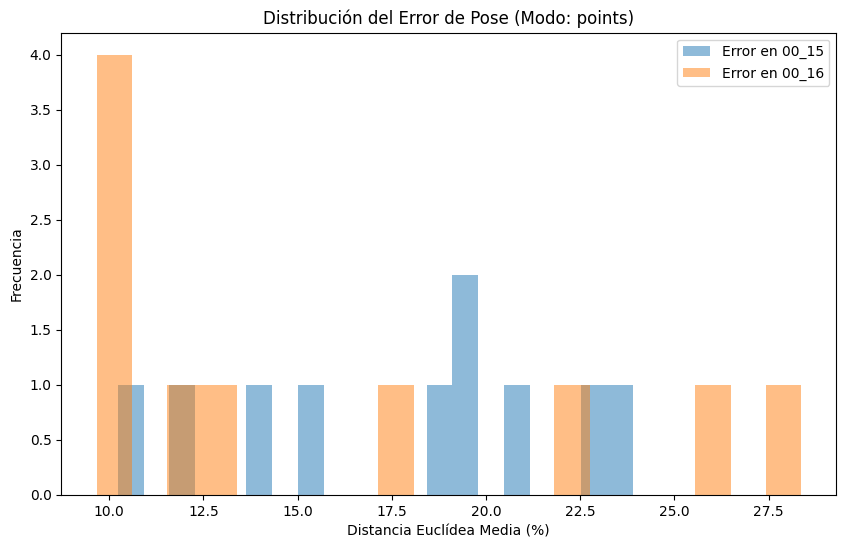

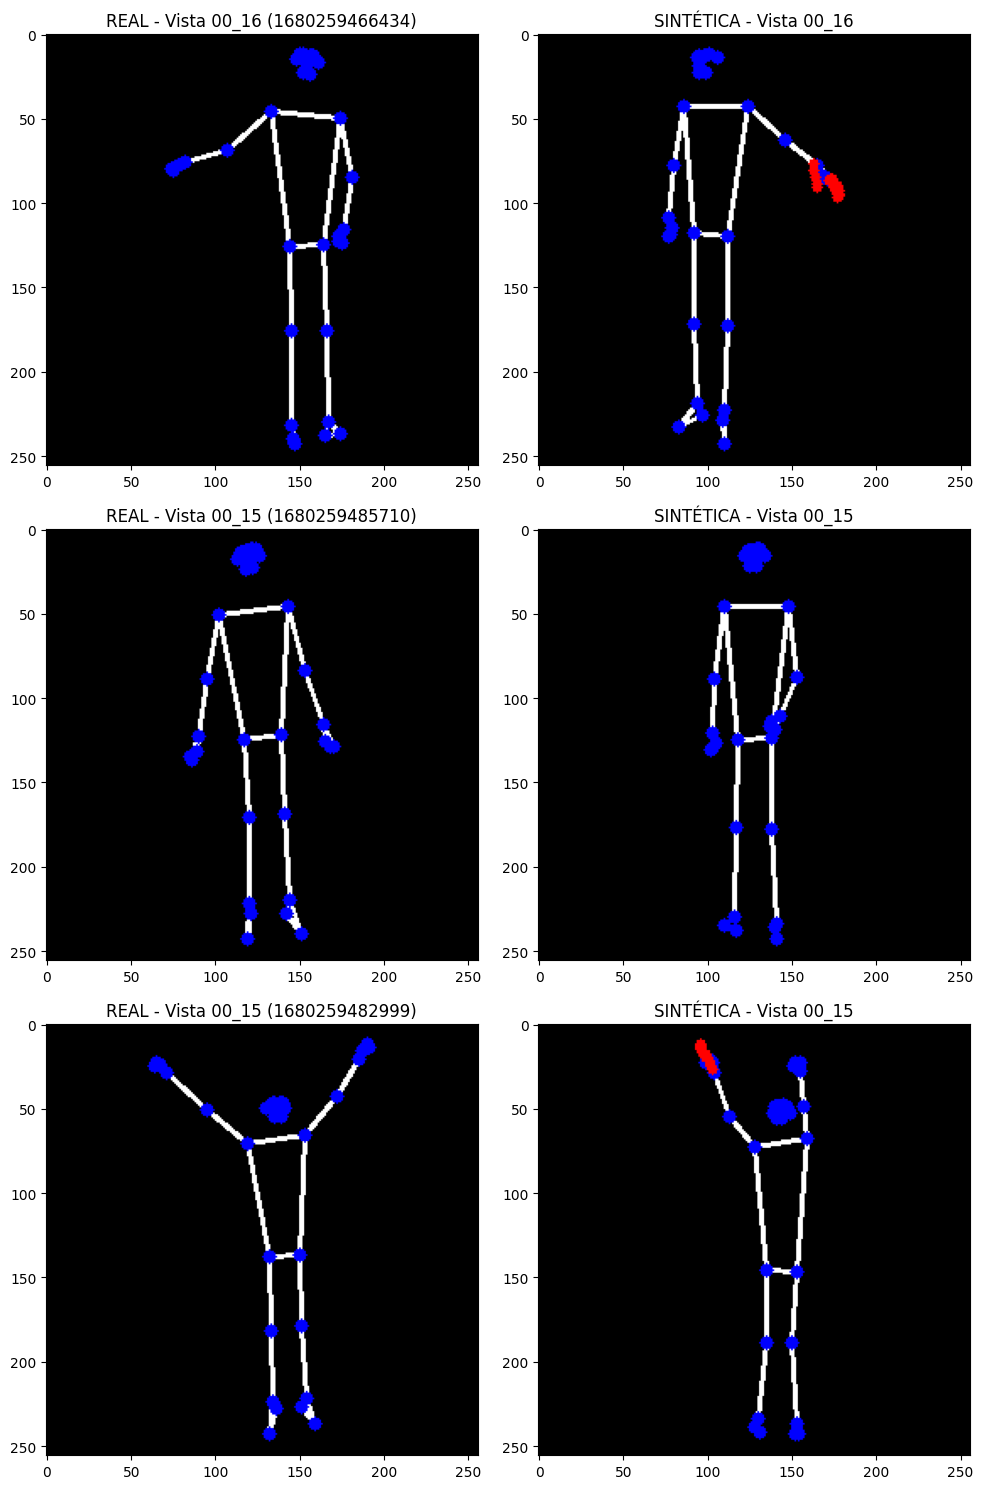

In [7]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# --- Tus funciones base (get_landmarks_from_image, normalize_landmarks, plot_landmarks) ---
# [Asume que aquí van las funciones que proporcionaste en tu primer mensaje]

def get_timestamp(filename):
    """Extrae el timestamp numérico del nombre del archivo."""
    # Ejemplo: 00_16_1680259461010_rgb.png -> 1680259461010
    parts = filename.split('_')
    for p in parts:
        if p.isdigit() and len(p) > 10:
            return p
    return None

def compute_metrics(lms_ref, lms_gen, mode="points"):
    """
    Calcula la diferencia entre dos conjuntos de landmarks.
    mode: "points" (Distancia Euclídea) o "pixels" (MSE de imágenes)
    """
    if not lms_ref or not lms_gen:
        return None

    # Solo comparamos las claves que existan en ambos (usualmente 'pose')
    common_keys = set(lms_ref.keys()) & set(lms_gen.keys())
    if not common_keys: return None

    if mode == "points":
        distances = []
        for k in common_keys:
            # Comparamos punto a punto
            for p1, p2 in zip(lms_ref[k], lms_gen[k]):
                dist = np.sqrt((p1.x - p2.x)**2 + (p1.y - p2.y)**2)
                distances.append(dist)
        return np.mean(distances) if distances else None

    elif mode == "pixels":
        # Generamos imágenes 100x100 para restar
        img_ref = plot_landmarks(lms_ref, tam=100, is_normalized=True)
        img_gen = plot_landmarks(lms_gen, tam=100, is_normalized=True)
        # Convertir a escala de grises para el error
        gray_ref = cv2.cvtColor(img_ref, cv2.COLOR_RGB2GRAY)
        gray_gen = cv2.cvtColor(img_gen, cv2.COLOR_RGB2GRAY)
        mse = np.mean((gray_ref.astype(float) - gray_gen.astype(float))**2)
        return mse

def run_study(base_path, target_views=["00_15", "00_16"], mode="points", limit=100):
    results = []
    comparisons_for_plot = []
    
    path_test = os.path.join(base_path, "test")
    path_gen_root = os.path.join(base_path, "00_17")

    for view in target_views:
        print(f"--- Analizando Vista {view} (Modo: {mode}) ---")
        real_dir = os.path.join(path_test, view)
        fake_dir = os.path.join(path_gen_root, f"to_{view}")
        
        # Mapear archivos reales por timestamp
        real_files = {get_timestamp(f): f for f in os.listdir(real_dir) if f.endswith(('.png', '.jpg'))}
        fake_files = os.listdir(fake_dir)
        
        count = 0
        for f_fake in tqdm(fake_files):
            if count >= limit: break
            
            ts = get_timestamp(f_fake)
            if ts in real_files:
                # 1. Extraer poses
                lms_fake, _ = get_landmarks_from_image(os.path.join(fake_dir, f_fake))
                lms_real, _ = get_landmarks_from_image(os.path.join(real_dir, real_files[ts]))
                
                if lms_fake and lms_real:
                    # 2. Normalizar
                    norm_fake = normalize_landmarks(lms_fake)
                    norm_real = normalize_landmarks(lms_real)
                    
                    # 3. Calcular Métrica
                    error = compute_metrics(norm_real, norm_fake, mode=mode)
                    
                    if error is not None:
                        results.append({
                            'view': view,
                            'timestamp': ts,
                            'error': error,
                            'mode': mode
                        })
                        # Guardar para el collage final
                        comparisons_for_plot.append((norm_real, norm_fake, view, ts))
                        count += 1

    # Guardar CSV
    df = pd.DataFrame(results)
    df.to_csv(f"estudio_pose_{mode}_{limit}_imgs.csv", index=False)
    
    # Generar Gráfica de Errores
    plt.figure(figsize=(10, 6))
    for view in target_views:
        subset = df[df['view'] == view]
        plt.hist(subset['error'], bins=20, alpha=0.5, label=f'Error en {view}')
    
    plt.title(f"Distribución del Error de Pose (Modo: {mode})")
    plt.xlabel("Error" if mode=="pixels" else "Distancia Euclídea Media (%)")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.savefig(f"grafica_error_{mode}.png")
    
    # Generar ejemplos visuales aleatorios
    generate_collage(comparisons_for_plot, mode)
    
    return df

def generate_collage(comparisons, mode, n_samples=3):
    samples = random.sample(comparisons, min(n_samples, len(comparisons)))
    fig, axes = plt.subplots(len(samples), 2, figsize=(10, 5 * len(samples)))
    
    for i, (real, fake, view, ts) in enumerate(samples):
        img_real = plot_landmarks(real, tam=256, is_normalized=True)
        img_fake = plot_landmarks(fake, tam=256, is_normalized=True)
        
        axes[i, 0].imshow(img_real)
        axes[i, 0].set_title(f"REAL - Vista {view} ({ts})")
        axes[i, 1].imshow(img_fake)
        axes[i, 1].set_title(f"SINTÉTICA - Vista {view}")
        
    plt.tight_layout()
    plt.savefig(f"ejemplos_comparacion_{mode}.png")
    print(f"Proceso finalizado. Resultados guardados en estudio_pose_{mode}.csv y gráficas generadas.")

# --- EJECUCIÓN ---
BASE_PATH = "/nas/antoniodetoro/qwen/Qwen-Image-Edit-Angles-2/MultiViewVisibleImagesHPE_100"
# Cambia mode="points" por mode="pixels" según necesites
df_results = run_study(BASE_PATH, mode="points", limit=10)

--- Analizando Vista 00_15 (Modo: pixels) ---


  0%|          | 0/101 [00:00<?, ?it/s]I0000 00:00:1769511806.259142 1235245 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1769511806.314117 1245970 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 560.35.05), renderer: NVIDIA A30/PCIe/SSE2
W0000 00:00:1769511806.359706 1245908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769511806.409377 1245923 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769511806.411625 1245911 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769511806.411639 1245969 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feed

--- Analizando Vista 00_16 (Modo: pixels) ---


  0%|          | 0/101 [00:00<?, ?it/s]I0000 00:00:1769511811.863909 1235245 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1769511811.913753 1247408 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 560.35.05), renderer: NVIDIA A30/PCIe/SSE2
W0000 00:00:1769511811.972059 1247346 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769511812.019025 1247357 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769511812.022596 1247388 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769511812.022890 1247386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feed

Proceso finalizado. Resultados guardados en estudio_pose_pixels.csv y gráficas generadas.


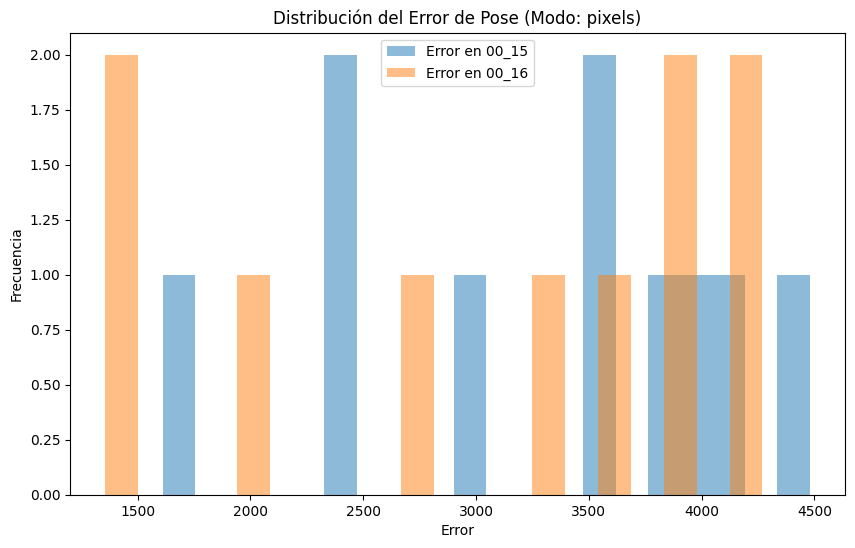

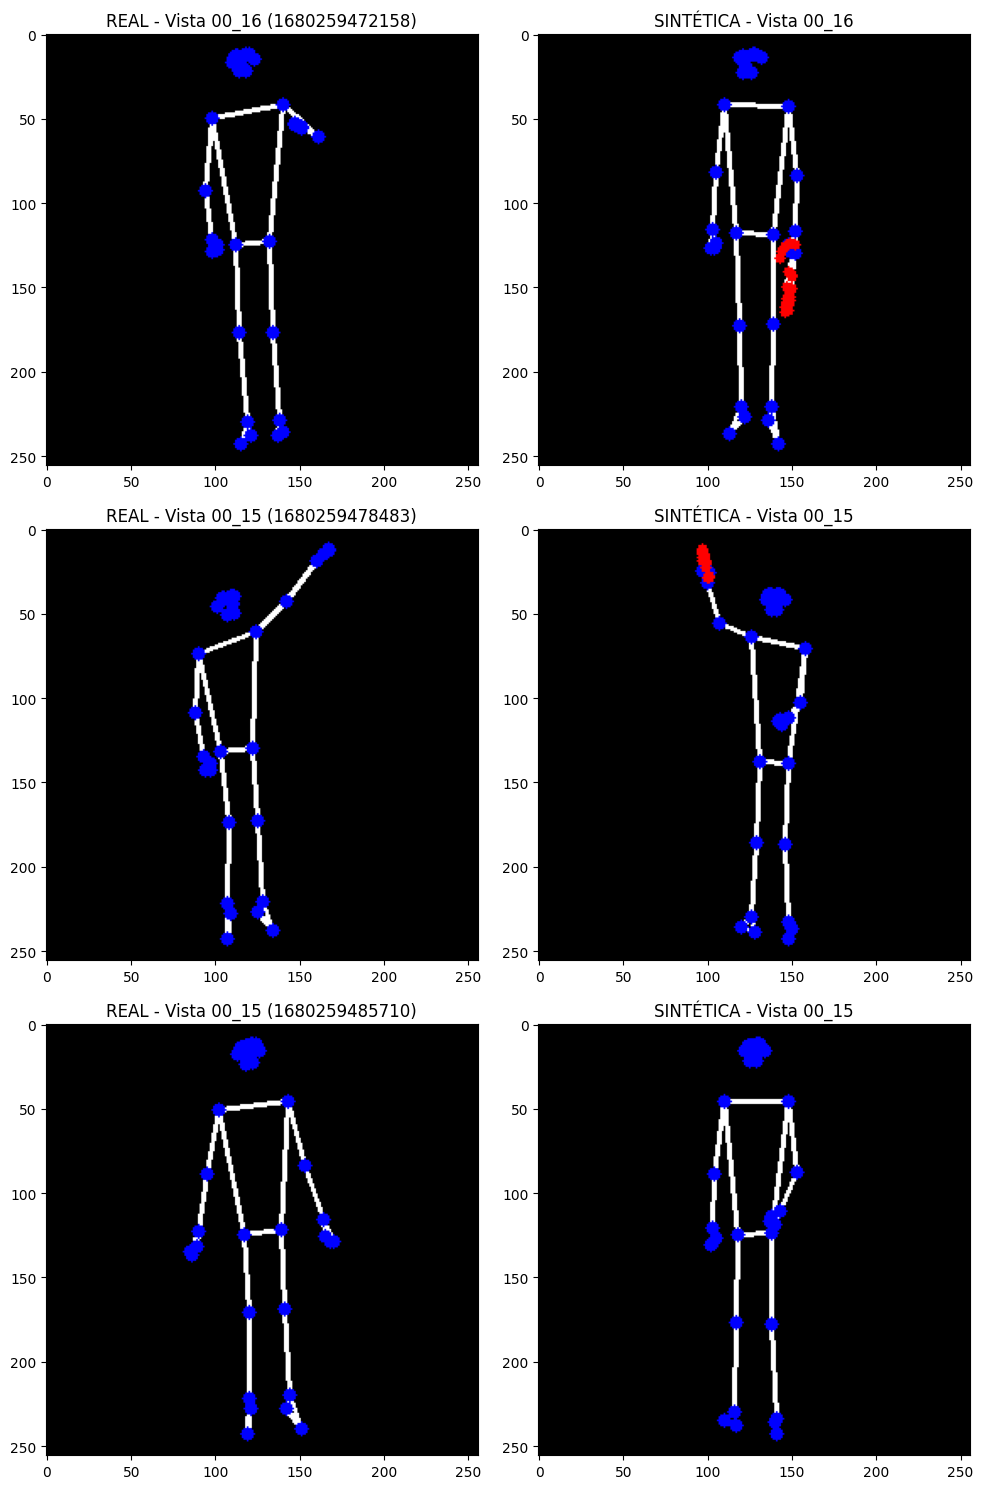

In [8]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# --- Tus funciones base (get_landmarks_from_image, normalize_landmarks, plot_landmarks) ---
# [Asume que aquí van las funciones que proporcionaste en tu primer mensaje]

def get_timestamp(filename):
    """Extrae el timestamp numérico del nombre del archivo."""
    # Ejemplo: 00_16_1680259461010_rgb.png -> 1680259461010
    parts = filename.split('_')
    for p in parts:
        if p.isdigit() and len(p) > 10:
            return p
    return None

def compute_metrics(lms_ref, lms_gen, mode="points"):
    """
    Calcula la diferencia entre dos conjuntos de landmarks.
    mode: "points" (Distancia Euclídea) o "pixels" (MSE de imágenes)
    """
    if not lms_ref or not lms_gen:
        return None

    # Solo comparamos las claves que existan en ambos (usualmente 'pose')
    common_keys = set(lms_ref.keys()) & set(lms_gen.keys())
    if not common_keys: return None

    if mode == "points":
        distances = []
        for k in common_keys:
            # Comparamos punto a punto
            for p1, p2 in zip(lms_ref[k], lms_gen[k]):
                dist = np.sqrt((p1.x - p2.x)**2 + (p1.y - p2.y)**2)
                distances.append(dist)
        return np.mean(distances) if distances else None

    elif mode == "pixels":
        # Generamos imágenes 100x100 para restar
        img_ref = plot_landmarks(lms_ref, tam=100, is_normalized=True)
        img_gen = plot_landmarks(lms_gen, tam=100, is_normalized=True)
        # Convertir a escala de grises para el error
        gray_ref = cv2.cvtColor(img_ref, cv2.COLOR_RGB2GRAY)
        gray_gen = cv2.cvtColor(img_gen, cv2.COLOR_RGB2GRAY)
        mse = np.mean((gray_ref.astype(float) - gray_gen.astype(float))**2)
        return mse

def run_study(base_path, target_views=["00_15", "00_16"], mode="points", limit=100):
    results = []
    comparisons_for_plot = []
    
    path_test = os.path.join(base_path, "test")
    path_gen_root = os.path.join(base_path, "00_17")

    for view in target_views:
        print(f"--- Analizando Vista {view} (Modo: {mode}) ---")
        real_dir = os.path.join(path_test, view)
        fake_dir = os.path.join(path_gen_root, f"to_{view}")
        
        # Mapear archivos reales por timestamp
        real_files = {get_timestamp(f): f for f in os.listdir(real_dir) if f.endswith(('.png', '.jpg'))}
        fake_files = os.listdir(fake_dir)
        
        count = 0
        for f_fake in tqdm(fake_files):
            if count >= limit: break
            
            ts = get_timestamp(f_fake)
            if ts in real_files:
                # 1. Extraer poses
                lms_fake, _ = get_landmarks_from_image(os.path.join(fake_dir, f_fake))
                lms_real, _ = get_landmarks_from_image(os.path.join(real_dir, real_files[ts]))
                
                if lms_fake and lms_real:
                    # 2. Normalizar
                    norm_fake = normalize_landmarks(lms_fake)
                    norm_real = normalize_landmarks(lms_real)
                    
                    # 3. Calcular Métrica
                    error = compute_metrics(norm_real, norm_fake, mode=mode)
                    
                    if error is not None:
                        results.append({
                            'view': view,
                            'timestamp': ts,
                            'error': error,
                            'mode': mode
                        })
                        # Guardar para el collage final
                        comparisons_for_plot.append((norm_real, norm_fake, view, ts))
                        count += 1

    # Guardar CSV
    df = pd.DataFrame(results)
    df.to_csv(f"estudio_pose_{mode}_{limit}_imgs.csv", index=False)
    
    # Generar Gráfica de Errores
    plt.figure(figsize=(10, 6))
    for view in target_views:
        subset = df[df['view'] == view]
        plt.hist(subset['error'], bins=20, alpha=0.5, label=f'Error en {view}')
    
    plt.title(f"Distribución del Error de Pose (Modo: {mode})")
    plt.xlabel("Error" if mode=="pixels" else "Distancia Euclídea Media (%)")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.savefig(f"grafica_error_{mode}.png")
    
    # Generar ejemplos visuales aleatorios
    generate_collage(comparisons_for_plot, mode)
    
    return df

def generate_collage(comparisons, mode, n_samples=3):
    samples = random.sample(comparisons, min(n_samples, len(comparisons)))
    fig, axes = plt.subplots(len(samples), 2, figsize=(10, 5 * len(samples)))
    
    for i, (real, fake, view, ts) in enumerate(samples):
        img_real = plot_landmarks(real, tam=256, is_normalized=True)
        img_fake = plot_landmarks(fake, tam=256, is_normalized=True)
        
        axes[i, 0].imshow(img_real)
        axes[i, 0].set_title(f"REAL - Vista {view} ({ts})")
        axes[i, 1].imshow(img_fake)
        axes[i, 1].set_title(f"SINTÉTICA - Vista {view}")
        
    plt.tight_layout()
    plt.savefig(f"ejemplos_comparacion_{mode}.png")
    print(f"Proceso finalizado. Resultados guardados en estudio_pose_{mode}.csv y gráficas generadas.")

# --- EJECUCIÓN ---
BASE_PATH = "/nas/antoniodetoro/qwen/Qwen-Image-Edit-Angles-2/MultiViewVisibleImagesHPE_100"
# Cambia mode="points" por mode="pixels" según necesites
df_results = run_study(BASE_PATH, mode="pixels", limit=10)

# Búsqueda Inversa
(Se comprueban las originales sólo de las generadas que se encuentren)

In [16]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm

# --- [AQUÍ VAN TUS FUNCIONES: get_landmarks_from_image, normalize_landmarks, plot_landmarks, etc.] ---

def run_study(base_path, limit=10, mode="pixels"):
    os.makedirs("analisis", exist_ok=True)
    
    path_test = os.path.join(base_path, "test")
    path_gen_root = os.path.join(base_path, "00_17")
    
    # Mapeo de archivos
    data_struct = {
        "00_15": {
            "fake_dir": os.path.join(path_gen_root, "to_00_15"),
            "real_dir": os.path.join(path_test, "00_15")
        },
        "00_16": {
            "fake_dir": os.path.join(path_gen_root, "to_00_16"),
            "real_dir": os.path.join(path_test, "00_16")
        }
    }

    # Obtener timestamps comunes (o simplemente de una carpeta ya que son iguales)
    sample_dir = data_struct["00_15"]["fake_dir"]
    all_timestamps = sorted([get_timestamp(f) for f in os.listdir(sample_dir) if get_timestamp(f)])
    
    selected_ts = all_timestamps[:limit]
    print(f"Procesando {len(selected_ts)} instantes de tiempo para vistas 15 y 16 (Total: {len(selected_ts)*2} comparaciones)")

    results = []
    comparisons = [] # Lista de (n_real, n_fake, view, ts, error)

    for ts in tqdm(selected_ts):
        for view in ["00_15", "00_16"]:
            # Localizar archivos por timestamp
            f_dir = data_struct[view]["fake_dir"]
            r_dir = data_struct[view]["real_dir"]
            
            # Buscar el archivo que contenga el timestamp
            f_file = next((f for f in os.listdir(f_dir) if ts in f), None)
            r_file = next((f for f in os.listdir(r_dir) if ts in f), None)

            if f_file and r_file:
                lms_fake, _ = get_landmarks_from_image(os.path.join(f_dir, f_file))
                lms_real, _ = get_landmarks_from_image(os.path.join(r_dir, r_file))
                
                if lms_fake and lms_real:
                    n_fake = normalize_landmarks(lms_fake)
                    n_real = normalize_landmarks(lms_real)
                    err = compute_metrics(n_real, n_fake, mode=mode)
                    
                    results.append({'ts': ts, 'view': view, 'error': err})
                    comparisons.append((n_real, n_fake, view, ts, err))

    # --- GENERAR PDF ---
    pdf_path = f"analisis/estudio_detallado_{mode}.pdf"
    with PdfPages(pdf_path) as pdf:
        # 1. Página de Resumen (Gráfica)
        df = pd.DataFrame(results)
        plt.figure(figsize=(10, 6))
        for view in ["00_15", "00_16"]:
            subset = df[df['view'] == view]
            if not subset.empty:
                plt.hist(subset['error'], bins=10, alpha=0.5, label=f'Vista {view}')
        plt.title(f"Distribución del Error ({mode.upper()})")
        plt.legend()
        pdf.savefig() 
        plt.close()

        # 2. Páginas de Comparación (Una por imagen)
        for real, fake, view, ts, err in comparisons:
            fig, axes = plt.subplots(1, 2, figsize=(12, 7))
            fig.patch.set_facecolor('#121212')
            
            img_r = plot_landmarks(real, tam=512, is_normalized=True)
            img_f = plot_landmarks(fake, tam=512, is_normalized=True)
            
            axes[0].imshow(img_r)
            axes[0].set_title(f"REAL - Vista {view}\nTS: {ts}", color='white')
            axes[0].axis('off')
            
            axes[1].imshow(img_f)
            axes[1].set_title(f"SINTÉTICA - Vista {view}\nError: {err:.4f}", color='cyan')
            axes[1].axis('off')
            
            plt.tight_layout()
            pdf.savefig(fig, facecolor=fig.get_facecolor())
            plt.close(fig)

    print(f"PDF generado con éxito: {pdf_path}")
    return df

# --- EJECUCIÓN ---
BASE_PATH = "/nas/antoniodetoro/qwen/Qwen-Image-Edit-Angles-2/MultiViewVisibleImagesHPE_Custom"
run_study(BASE_PATH, limit=10, mode="pixels")

Procesando 10 instantes de tiempo para vistas 15 y 16 (Total: 20 comparaciones)


  0%|          | 0/10 [00:00<?, ?it/s]I0000 00:00:1769517556.311384 1235245 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1769517556.375955 1422474 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 560.35.05), renderer: NVIDIA A30/PCIe/SSE2
W0000 00:00:1769517556.449633 1422413 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769517556.498804 1422426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769517556.501364 1422411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769517556.501424 1422443 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedb

PDF generado con éxito: analisis/estudio_detallado_pixels.pdf


,ts,view,error
0,1680259600117,00_15,1150.0412
1,1680259600117,00_16,1338.8607
2,1680259600418,00_16,751.8972
3,1680259600719,00_15,481.4988
4,1680259600719,00_16,898.3265
5,1680259601322,00_15,717.8472
6,1680259601322,00_16,1452.7294
7,1680259601623,00_15,915.8088
8,1680259601623,00_16,1359.5769
9,1680259601924,00_15,2690.1475


In [7]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm

# --- FUNCIONES BASE AJUSTADAS ---

def get_landmarks_from_image(image_path):
    with mp_holistic.Holistic(static_image_mode=True, min_detection_confidence=0.4) as holistic:
        image = cv2.imread(image_path)
        if image is None: return {}, None, None
        
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = holistic.process(image_rgb)
        
        all_lms = {}
        if results.pose_landmarks:
            all_lms["pose"] = [Landmark(lm.x, lm.y, i) for i, lm in enumerate(results.pose_landmarks.landmark)]
        if results.left_hand_landmarks:
            all_lms["left_hand"] = [Landmark(lm.x, lm.y) for lm in results.left_hand_landmarks.landmark]
        if results.right_hand_landmarks:
            all_lms["right_hand"] = [Landmark(lm.x, lm.y) for lm in results.right_hand_landmarks.landmark]
            
        return all_lms, image_rgb, image_rgb

def run_study(base_path, limit=10, mode="pixels"):
    os.makedirs("analisis", exist_ok=True)
    path_test = os.path.join(base_path, "test")
    path_gen_root = os.path.join(base_path, "00_17")
    
    results_data = []
    comparisons = [] 

    for view in ["00_15", "00_16"]:
        fake_dir = os.path.join(path_gen_root, f"to_{view}")
        real_dir = os.path.join(path_test, view)
        
        # FILTRO: Solo archivos que contengan 'rgb' y terminen en imagen
        fakes = {get_timestamp(f): f for f in os.listdir(fake_dir) if 'rgb' in f and f.endswith(('.png', '.jpg'))}
        reals = {get_timestamp(f): f for f in os.listdir(real_dir) if 'rgb' in f and f.endswith(('.png', '.jpg'))}
        
        all_ts = sorted(list(set(fakes.keys()) & set(reals.keys())))
        selected_ts = all_ts[:limit]
        
        print(f"\nProcesando Vista {view} ({len(selected_ts)} imágenes)...")
        
        for ts in tqdm(selected_ts):
            # Extraer landmarks e imágenes (aunque no detecte pose, devuelve la imagen)
            lms_f, _, img_f_raw = get_landmarks_from_image(os.path.join(fake_dir, fakes[ts]))
            lms_r, _, img_r_raw = get_landmarks_from_image(os.path.join(real_dir, reals[ts]))
            
            # Normalizar (si lms está vacío, devuelve {} o maneja el error)
            n_f = normalize_landmarks(lms_f) if lms_f else {}
            n_r = normalize_landmarks(lms_r) if lms_r else {}
            
            # Calcular métrica (maneja None internamente)
            err = compute_metrics(n_r, n_f, mode=mode) if (n_r and n_f) else 0.0
            
            results_data.append({'ts': ts, 'view': view, 'error': err})
            comparisons.append((img_r_raw, img_f_raw, n_r, n_f, view, ts, err))

    # --- GENERACIÓN DEL PDF ---
    pdf_path = f"analisis/comparativa_completa_{mode}.pdf"
    with PdfPages(pdf_path) as pdf:
        # Pág 1: Histograma (solo de los que tienen error > 0)
        df = pd.DataFrame(results_data)
        plt.figure(figsize=(10, 5))
        for v in ["00_15", "00_16"]:
            subset = df[(df['view'] == v) & (df['error'] > 0)]
            if not subset.empty: plt.hist(subset['error'], bins=10, alpha=0.5, label=f'Vista {v}')
        plt.title(f"Distribución del Error {mode.upper()} (Solo detecciones válidas)")
        plt.legend()
        pdf.savefig(); plt.close()

        # Páginas de datos (2x2)
        for img_r, img_f, p_r, p_f, view, ts, err in comparisons:
            fig, axes = plt.subplots(2, 2, figsize=(12, 12))
            fig.patch.set_facecolor('#1e1e1e')
            
            # Fila 1: Originales (Control de nulos para imshow)
            if img_r is not None: axes[0, 0].imshow(img_r)
            axes[0, 0].set_title(f"REAL ORIGINAL (Vista {view})", color='white')
            
            if img_f is not None: axes[0, 1].imshow(img_f)
            axes[0, 1].set_title(f"SINTÉTICA GENERADA", color='cyan')
            
            # Fila 2: Poses (Si p_r/p_f están vacíos, plot_landmarks dibujará canvas negro)
            skeleton_r = plot_landmarks(p_r, tam=512, is_normalized=True)
            skeleton_f = plot_landmarks(p_f, tam=512, is_normalized=True)
            
            axes[1, 0].imshow(skeleton_r)
            axes[1, 0].set_title(f"POSE REAL {'(No detectada)' if not p_r else ''}", color='white')
            
            axes[1, 1].imshow(skeleton_f)
            axes[1, 1].set_title(f"POSE SINT. {'(No detectada)' if not p_f else ''}\nError: {err:.2f}", color='cyan')
            
            for ax in axes.ravel(): ax.axis('off')
            
            plt.suptitle(f"Timestamp: {ts}", color='yellow', fontsize=16)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            pdf.savefig(fig, facecolor=fig.get_facecolor())
            plt.close(fig)

    print(f"Estudio completado. PDF generado con {len(comparisons)} comparaciones.")

# --- EJECUCIÓN ---
run_study(BASE_PATH, limit=10, mode="points")


Procesando Vista 00_15 (10 imágenes)...


  0%|          | 0/10 [00:00<?, ?it/s]I0000 00:00:1769532466.018709 2022565 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1769532466.077147 2112154 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 560.35.05), renderer: NVIDIA A30/PCIe/SSE2
W0000 00:00:1769532466.143853 2112094 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769532466.177125 2112111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769532466.178876 2112141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769532466.179378 2112152 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedb


Procesando Vista 00_16 (10 imágenes)...


  0%|          | 0/10 [00:00<?, ?it/s]I0000 00:00:1769532470.619374 2022565 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1769532470.670351 2113748 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 560.35.05), renderer: NVIDIA A30/PCIe/SSE2
W0000 00:00:1769532470.721454 2113689 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769532470.750885 2113701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769532470.752556 2113738 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769532470.752662 2113696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedb

Estudio completado. PDF generado con 20 comparaciones.
